In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
from IPython import display

from sklearn.datasets import load_boston, load_breast_cancer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import nn_modules as nn
import nn_optimization as optim
from qpfs import QPFS

plt.rcParams['text.usetex'] = True
%config InlineBackend.figure_format = 'retina'
cmap = sns.light_palette((210, 90, 60), 10, input="husl")
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['axes.labelsize'] = 20

In [217]:
X, y = load_boston(return_X_y=True)
X = (X - X.mean(axis=0)) / X.std(axis=0)

n_samples, n_features = X.shape

def nearest_point(x, y, X_grid, Y_grid):
    return np.argmin((Y_grid - y) ** 2), np.argmin((X_grid - x) ** 2)

#### Эксперимент

In [3]:
fs_corr = QPFS(sim='corr')
fs_info = QPFS(sim='info')

fs_corr.fit(X, y)
fs_info.fit(X, y)

fs_corr.status, fs_info.status

('optimal', 'optimal')

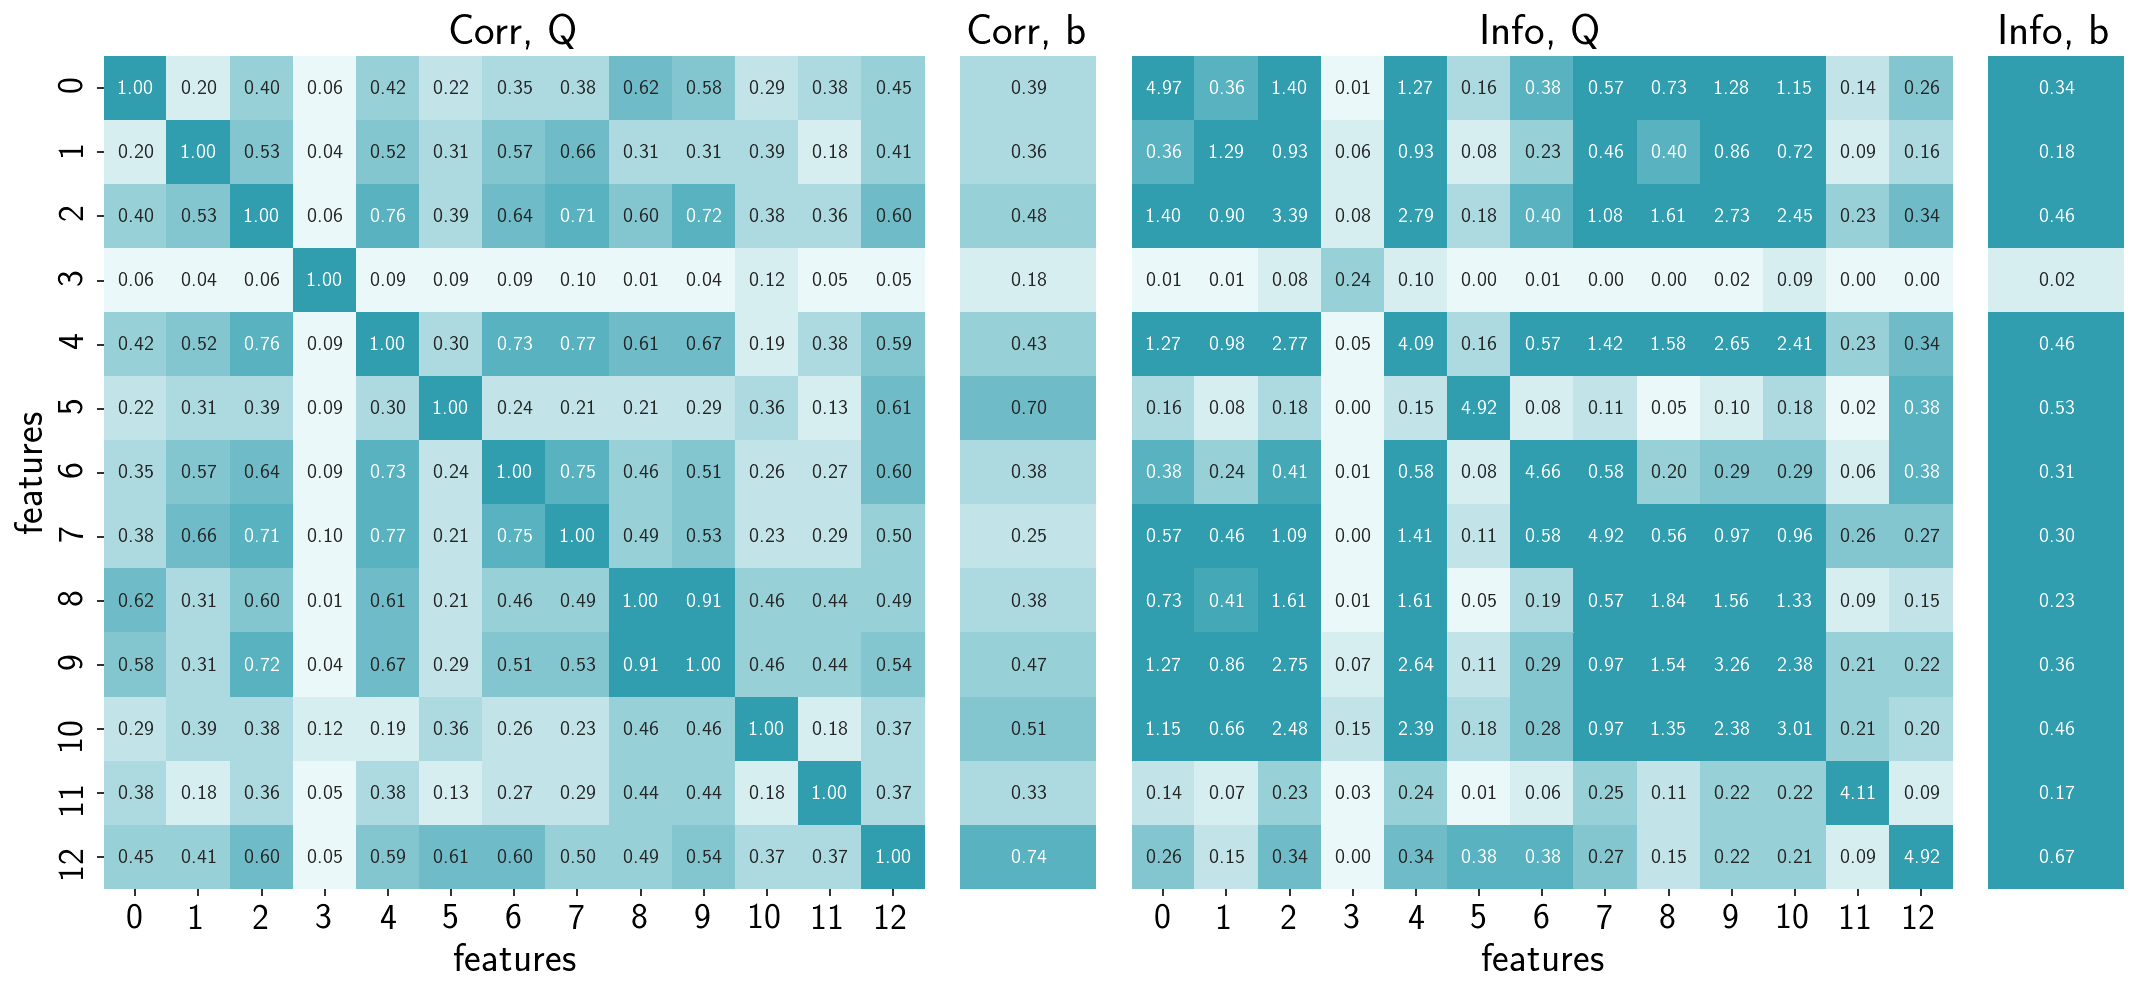

In [4]:
plt.figure(figsize=(15, 7))
ax1 = plt.subplot2grid((1, 12), (0, 0), colspan=5)
ax3 = plt.subplot2grid((1, 12), (0, 5))
ax2 = plt.subplot2grid((1, 12), (0, 6), colspan=5)
ax4 = plt.subplot2grid((1, 12), (0, 11))

sns.heatmap(fs_corr.Q, cmap=cmap, vmin=0., vmax=1., cbar=False, annot=True, fmt='.2f', ax=ax1)
ax1.set_title('Corr, Q')
ax1.set_xlabel('features')
ax1.set_ylabel('features')

sns.heatmap(fs_info.Q, cmap=cmap, vmin=0., vmax=.5, cbar=False, annot=True, fmt='.2f', ax=ax2, yticklabels=False)
ax2.set_title('Info, Q')
ax2.set_xlabel('features')
#ax2.set_ylabel('features')

sns.heatmap(fs_corr.b, cmap=cmap, vmin=0., vmax=1., cbar=False, annot=True, fmt='.2f', ax=ax3, xticklabels=False, yticklabels=False)
ax3.set_title('Corr, b')
#ax3.set_xlabel('features')
#ax3.set_ylabel('features')

sns.heatmap(fs_info.b, cmap=cmap, vmin=0., vmax=.1, cbar=False, annot=True, fmt='.2f', ax=ax4, xticklabels=False, yticklabels=False)
ax4.set_title('Info, b')
#ax4.set_xlabel('features')
#ax4.set_ylabel('features')

plt.subplots_adjust()
plt.tight_layout()
plt.show()

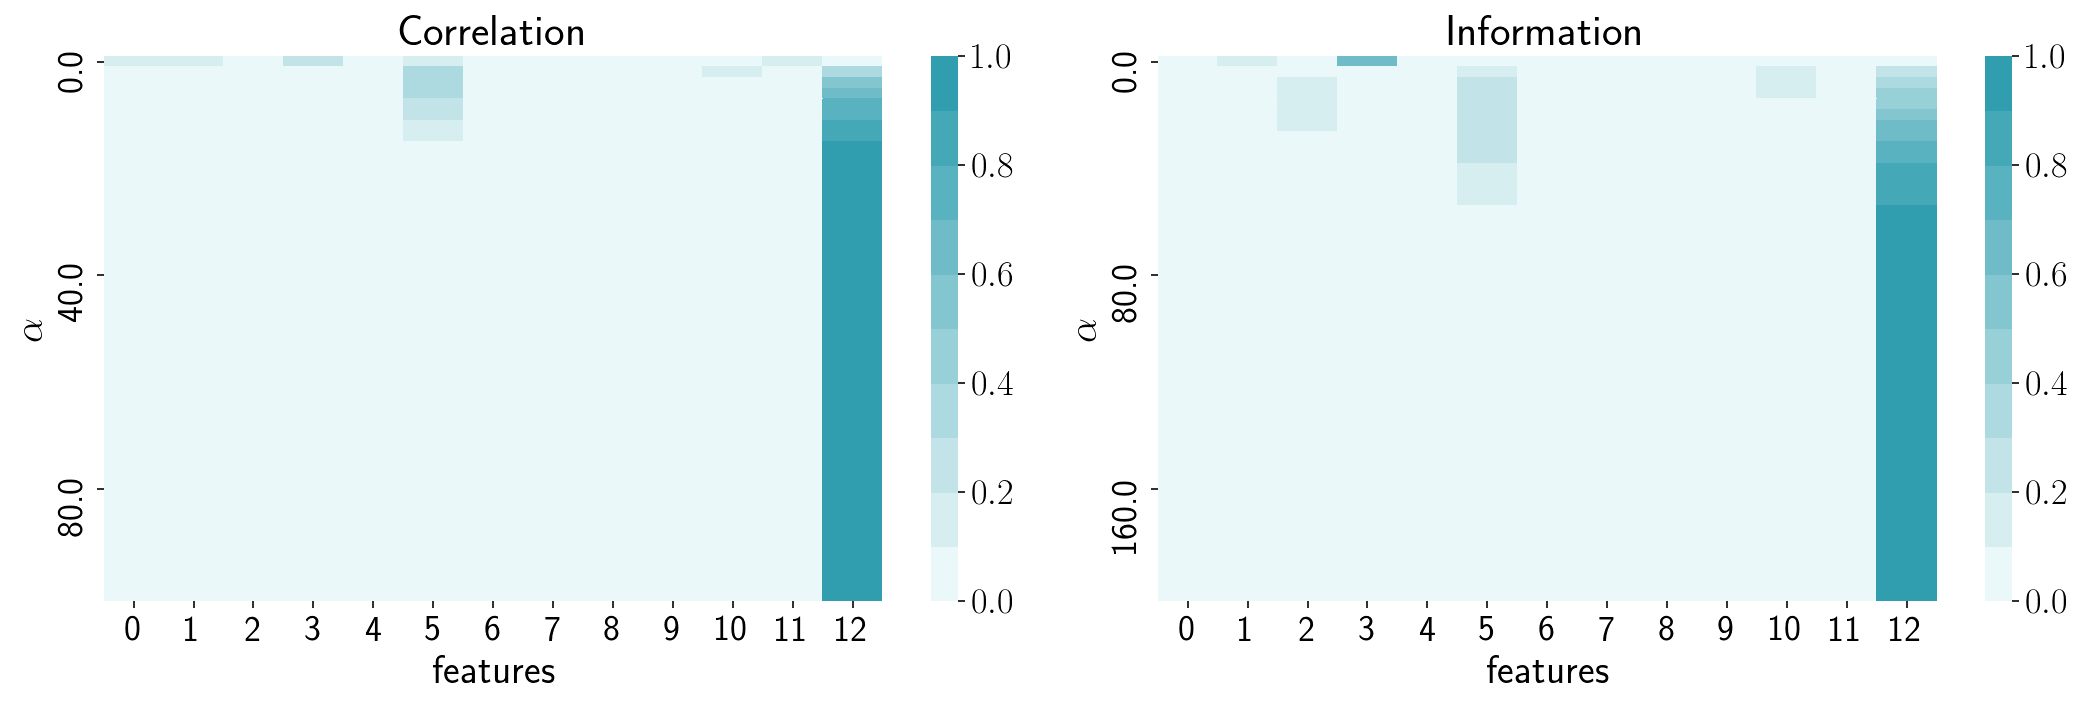

In [8]:
fs_corr.get_Qb(X, y)
z_scores = []
alphas = np.linspace(0, 100, 51)

for alpha in alphas:
    fs_corr.alpha = alpha
    fs_corr.solve_problem()
    z_scores.append(fs_corr.score)

z_scores_corr = pd.DataFrame(z_scores, index=alphas)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.heatmap(z_scores_corr, yticklabels=20, vmin=0., vmax=1., cmap=cmap)
plt.title('Correlation')
plt.xlabel('features')
plt.ylabel(r'$\alpha$')

fs_info.get_Qb(X, y)
z_scores = []
alphas = np.linspace(0, 200, 51)

for alpha in alphas:
    fs_info.alpha = alpha
    fs_info.solve_problem()
    z_scores.append(fs_info.score)
    
z_scores_info = pd.DataFrame(z_scores, index=alphas)

plt.subplot(1, 2, 2)
sns.heatmap(z_scores_info, yticklabels=20, cmap=cmap)
plt.title('Information')
plt.xlabel('features')
plt.ylabel(r'$\alpha$')

plt.subplots_adjust()
plt.tight_layout()
plt.savefig('figs/qpfs_corr_vs_info_wrt_alpha.eps', format='eps')
plt.show()

In [9]:
# batch generator
def get_batches(dataset, batch_size, shuffle=True):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    if shuffle:
        np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]
        
def visualize(loss, filename):
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 5))
    plt.xlabel("epochs", fontsize=16)
    plt.ylabel("loss", fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.semilogy(loss, 'b')
    plt.tight_layout()
    #plt.savefig('figs/{}.eps'.format(filename), format='eps')
    plt.show()

In [10]:
def train(net, X_train, y_train, X_test, y_test, batch_size, n_epoch, optimizer_method, criterion,
          optimizer_config, optimizer_state, weight_decay=False, filename='orig_net'):
    loss_history = []
    loss_history_epoch = []
    
    for i in range(n_epoch):
        loss_history_epoch.append(0.)
        if weight_decay and i % 20 == 0:
            optimizer_config['learning_rate'] *= .5
            
        for x_batch, y_batch in get_batches((X_train, y_train), batch_size):

            net.zeroGradParameters()

            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            # Update weights

            optimizer_method(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)

            loss_history.append(loss)
            loss_history_epoch[-1] += loss
        

        # Visualize
        visualize(loss_history_epoch, filename)

        print('Current loss: %f' % loss)
    return loss_history

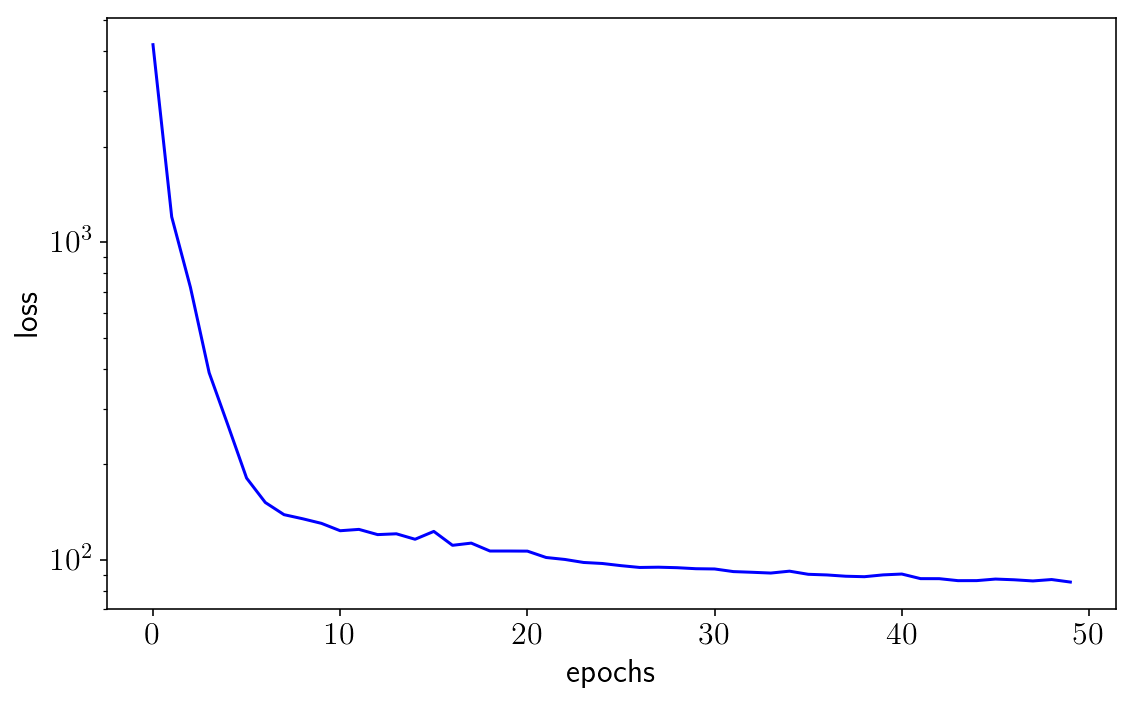

Current loss: 8.220513


In [11]:
n_hidden = 8

net = nn.Sequential()
net.add(nn.Linear(n_features, n_hidden))
net.add(nn.ReLU())
net.add(nn.Linear(n_hidden, 1))
net.add(nn.ELU())

criterion = nn.MSECriterion()

# Iptimizer params
optimizer_config = {'learning_rate' : 0.01, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 50
batch_size = 64

loss_history = train(net, X, y, X, y, batch_size, n_epoch, optim.sgd_momentum, criterion,
                     optimizer_config, optimizer_state, weight_decay=True)

f = net.forward(X).squeeze()

In [12]:
def get_Jacobian(X, y, net, idx_mod=0):
    J = np.zeros([n_samples, np.prod(net.modules[idx_mod].W.shape)])
    for i, (x_batch, y_batch) in enumerate(get_batches((X, y), batch_size=1, shuffle=False)):
        pred = net.forward(x_batch)
        net.backward(x_batch, np.array([[1.]]))
        J[i, :] = net.modules[idx_mod].gradW.ravel('F')
    return J

In [13]:
J1 = get_Jacobian(X, y, net, 0)
J2 = get_Jacobian(X, y, net, 2)

print(J1.shape, J2.shape)

(506, 104) (506, 8)


In [14]:
J1fs_corr = QPFS(sim='corr')
J1fs_info = QPFS(sim='symuncert')

J1fs_corr.get_Qb(J1, y - f)
J1fs_info.get_Qb(J1, y - f)

J2fs_corr = QPFS(sim='corr')
J2fs_info = QPFS(sim='symuncert')

J2fs_corr.get_Qb(J2, y - f)
J2fs_info.get_Qb(J2, y - f)

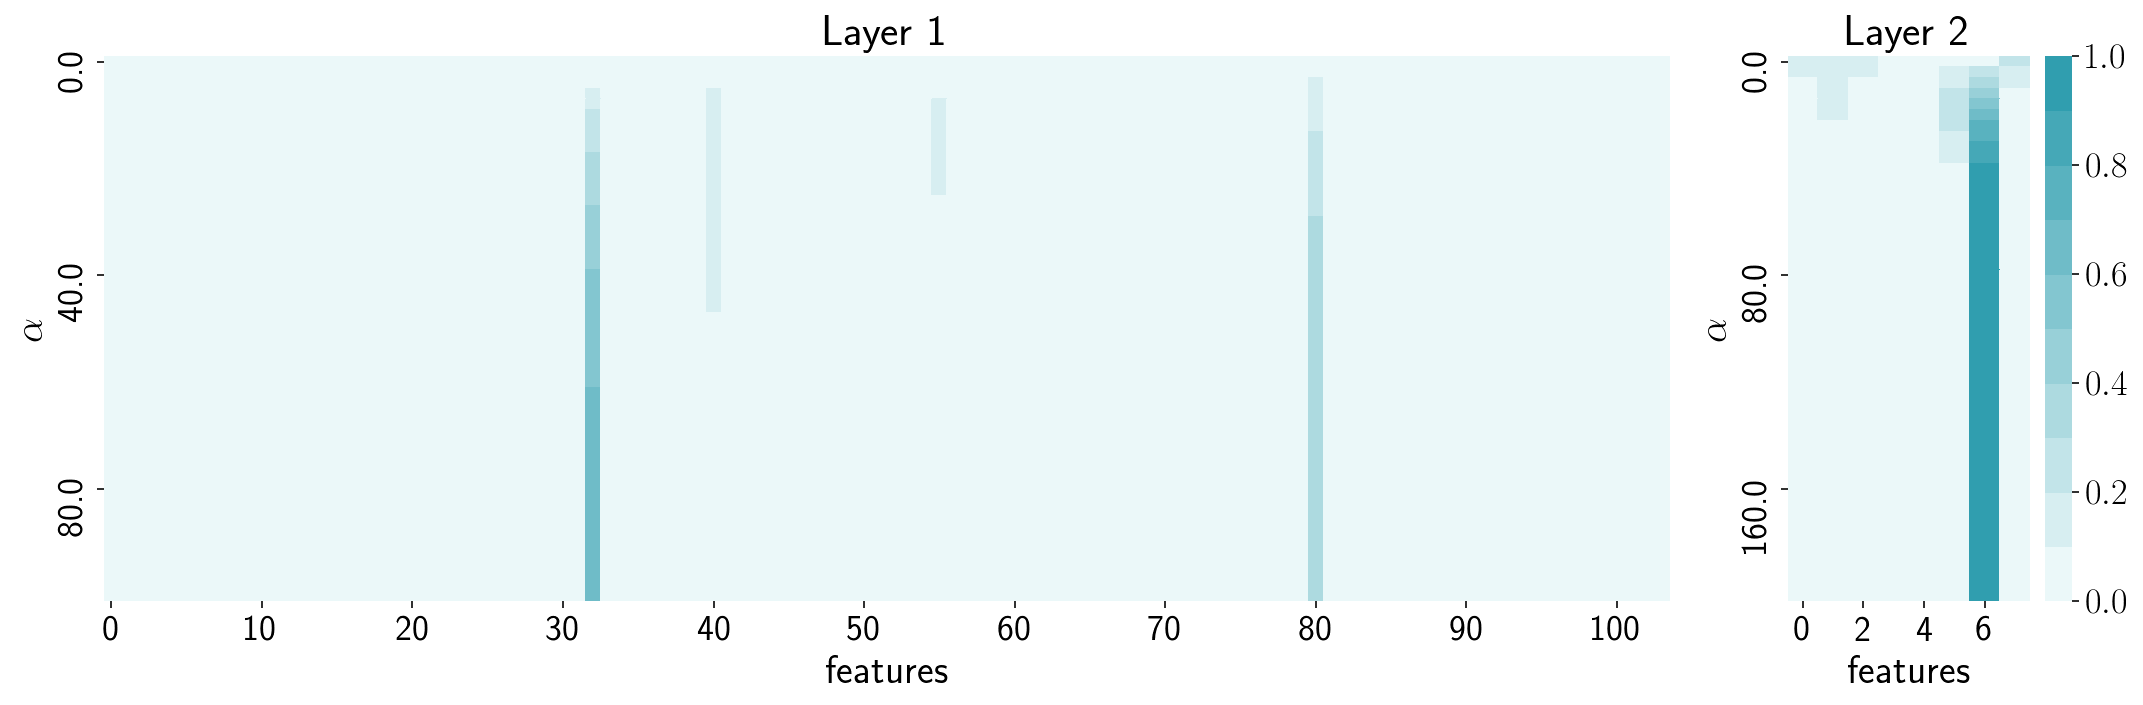

In [15]:
# Correlation
plt.figure(figsize=(15, 5))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=4)
ax2 = plt.subplot2grid((1, 5), (0, 4))

z_scores = []
alphas = np.linspace(0, 100, 51)

for alpha in alphas:
    J1fs_corr.alpha = alpha
    J1fs_corr.solve_problem()
    z_scores.append(J1fs_corr.score)
    
z_scores_corr = pd.DataFrame(z_scores, index=alphas)
    
sns.heatmap(z_scores_corr, yticklabels=20, xticklabels=10, cmap=cmap, vmin=0., vmax=1., ax=ax1, cbar=False)
ax1.set_title('Layer 1')
ax1.set_xlabel('features')
ax1.set_ylabel(r'$\alpha$')

z_scores = []
alphas = np.linspace(0, 200, 51)

for alpha in alphas:
    J2fs_corr.alpha = alpha
    J2fs_corr.solve_problem()
    z_scores.append(J2fs_corr.score)
    
z_scores_corr = pd.DataFrame(z_scores, index=alphas)
    
sns.heatmap(z_scores_corr, yticklabels=20, vmin=0., vmax=1., cmap=cmap, ax=ax2)
ax2.set_title('Layer 2')
ax2.set_xlabel('features')
ax2.set_ylabel(r'$\alpha$')

plt.subplots_adjust()
plt.tight_layout()

plt.savefig('figs/qpfs_nn_corr_wrt_alpha.eps', format='eps')
plt.show()

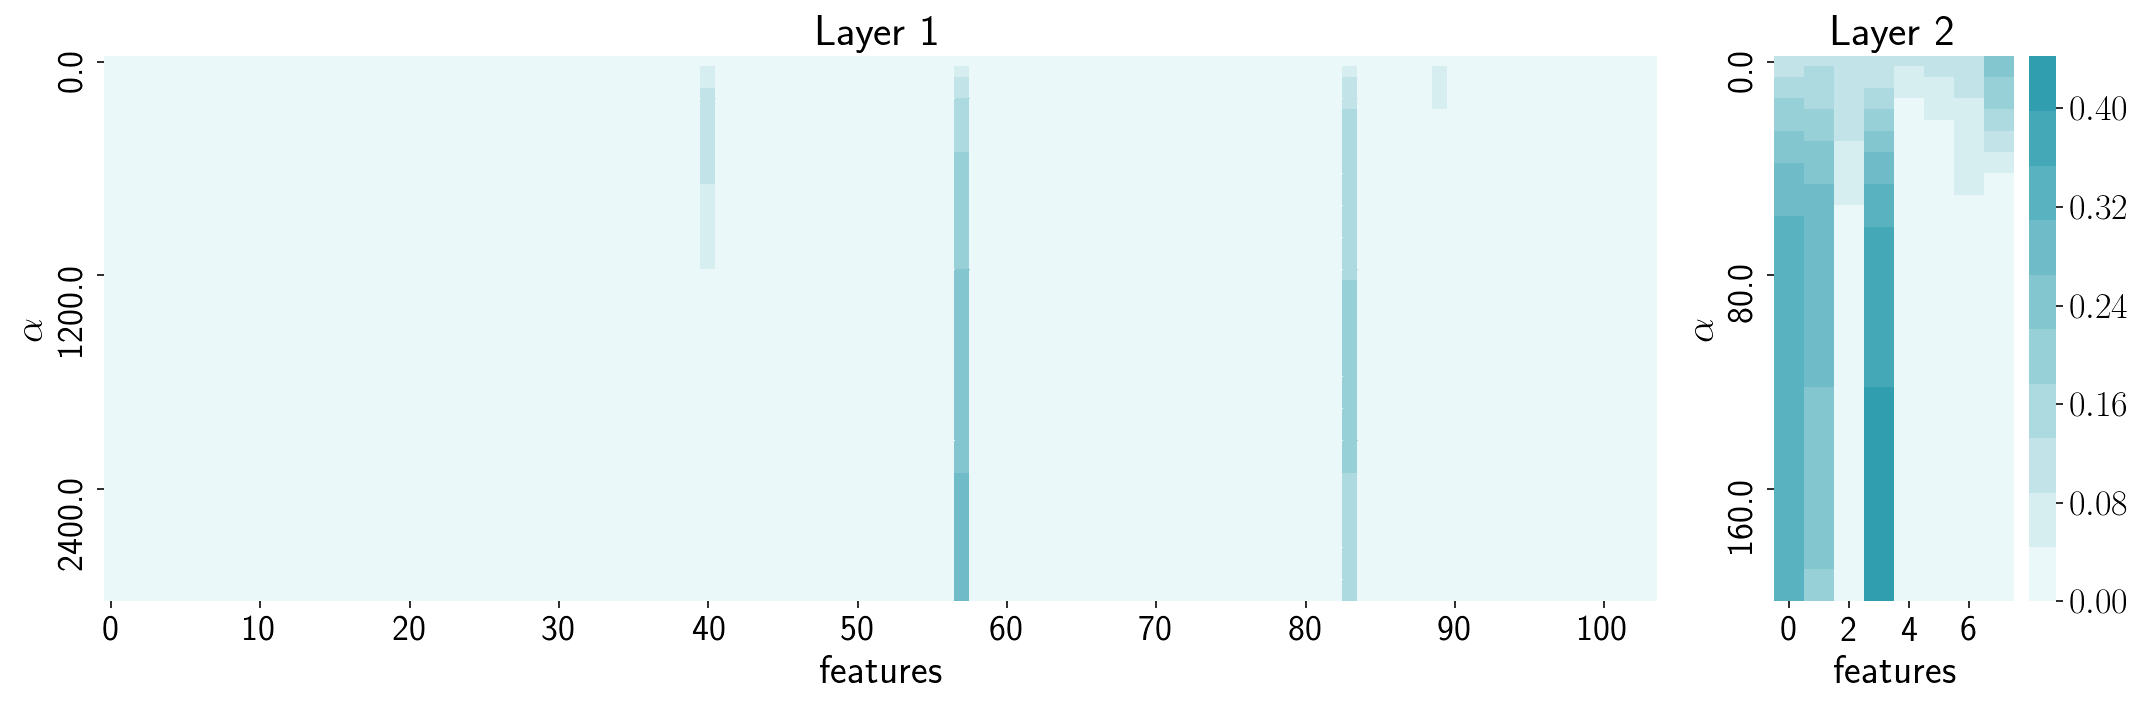

In [16]:
plt.figure(figsize=(15, 5))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=4)
ax2 = plt.subplot2grid((1, 5), (0, 4))

z_scores = []
alphas = np.linspace(0, 3000, 51)

for alpha in alphas:
    J1fs_info.alpha = alpha
    J1fs_info.solve_problem()
    z_scores.append(J1fs_info.score)
    
z_scores_info = pd.DataFrame(z_scores, index=alphas)
    
sns.heatmap(z_scores_info, yticklabels=20, xticklabels=10, vmin=0., vmax=1., cmap=cmap, ax=ax1, cbar=False)
ax1.set_title('Layer 1')
ax1.set_xlabel('features')
ax1.set_ylabel(r'$\alpha$')

z_scores = []
alphas = np.linspace(0, 200, 51)

for alpha in alphas:
    J2fs_info.alpha = alpha
    J2fs_info.solve_problem()
    z_scores.append(J2fs_info.score)
    
    
z_scores_info = pd.DataFrame(z_scores, index=alphas)
    
sns.heatmap(z_scores_info, yticklabels=20, cmap=cmap, ax=ax2)
ax2.set_title('Layer 2')
ax2.set_xlabel('features')
ax2.set_ylabel(r'$\alpha$')

plt.subplots_adjust()
plt.tight_layout()

plt.savefig('figs/qpfs_nn_info_wrt_alpha.eps', format='eps')
plt.show()

In [18]:
J1fs_corr.alpha = J1fs_corr.get_alpha()
J1fs_info.alpha = J1fs_info.get_alpha()

J1fs_corr.solve_problem()
J1fs_info.solve_problem()

In [19]:
J2fs_corr.alpha = J2fs_corr.get_alpha()
J2fs_info.alpha = J2fs_info.get_alpha()

J2fs_corr.solve_problem()
J2fs_info.solve_problem()

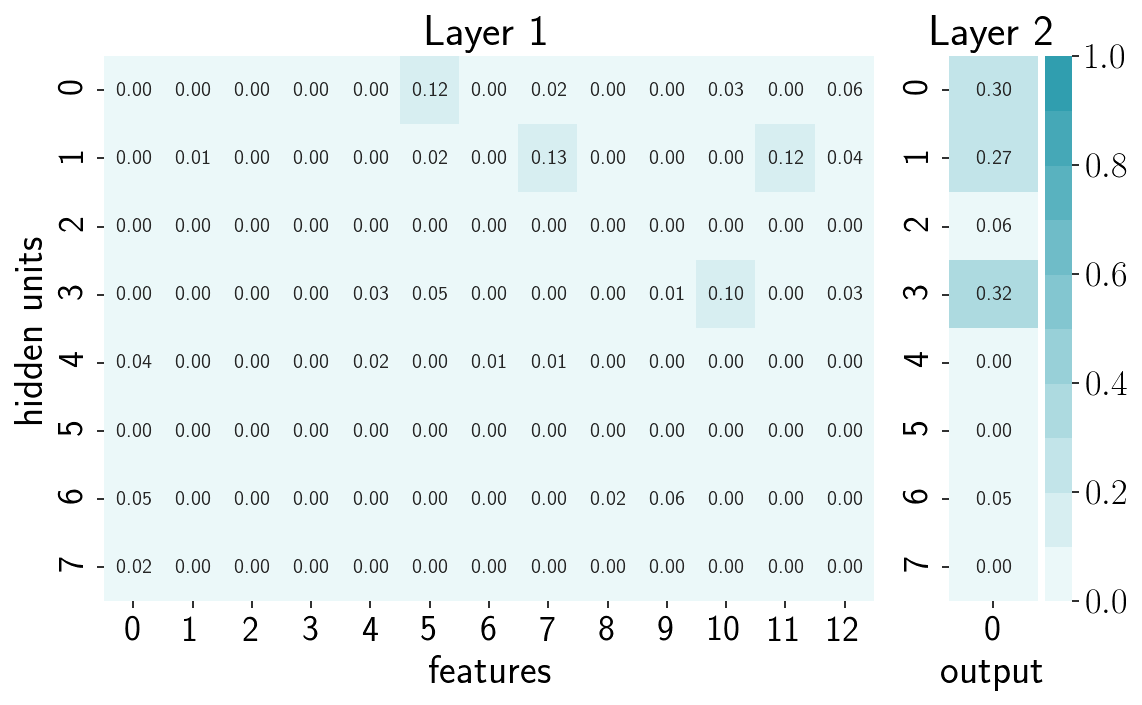

In [20]:
plt.figure(figsize=(8, 5))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=4)
ax2 = plt.subplot2grid((1, 5), (0, 4))
sns.heatmap(J1fs_info.score.reshape([n_features, n_hidden]).T, cmap=cmap, cbar=False,
            vmin=0., vmax=1., ax=ax1, annot=True, fmt='.2f')
ax1.set_title('Layer 1')
ax1.set_xlabel('features')
ax1.set_ylabel('hidden units')

sns.heatmap(J2fs_info.score.reshape([n_hidden, 1]), cmap=cmap, vmin=0., vmax=1., ax=ax2, annot=True, fmt='.2f', 
            cbar_kws={"fraction": .3})
ax2.set_title('Layer 2')
ax2.set_xlabel('output')
#ax2.set_ylabel('hidden units')

plt.subplots_adjust()
plt.tight_layout()

plt.savefig('figs/qpfs_nn_weight_maps.eps', format='eps')
plt.show()

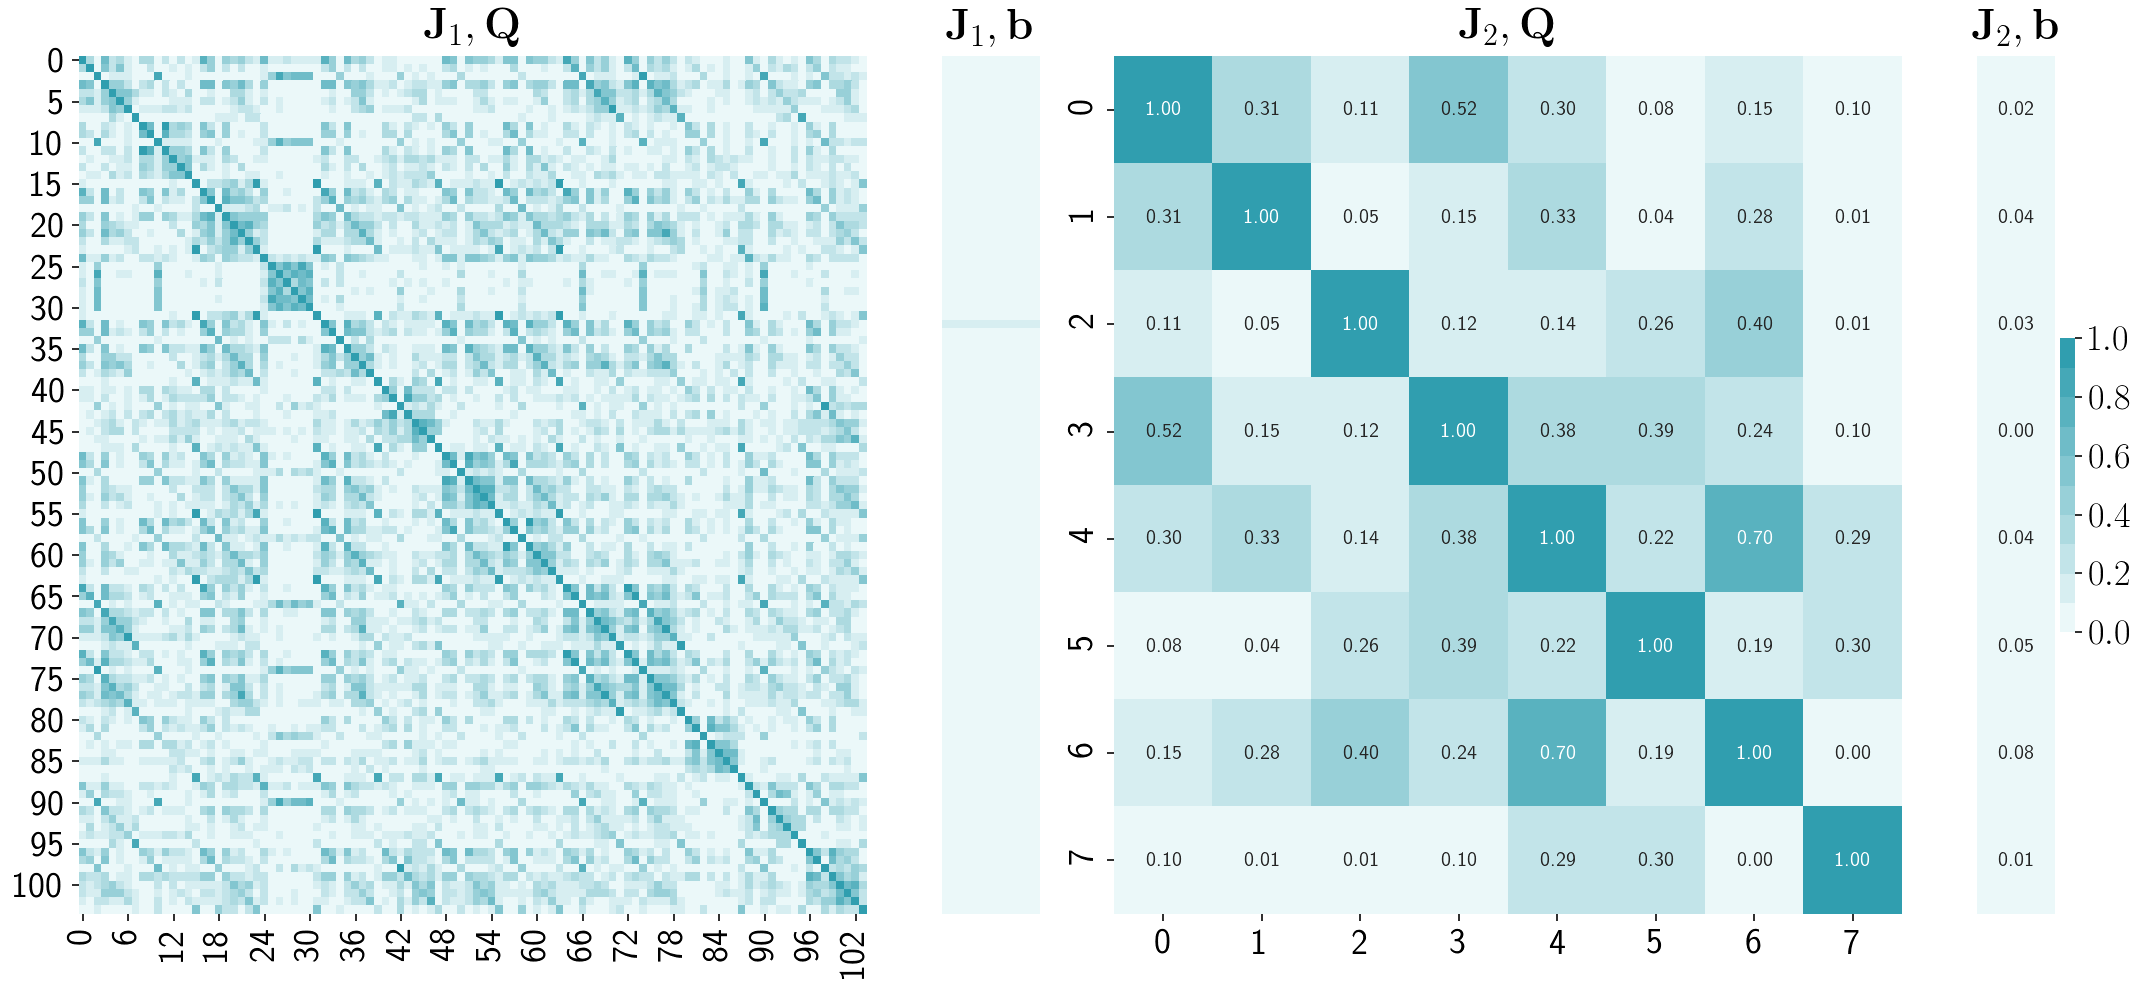

In [21]:
plt.figure(figsize=(15, 7))
ax1 = plt.subplot2grid((1, 12), (0, 0), colspan=5)
ax3 = plt.subplot2grid((1, 12), (0, 5))
ax2 = plt.subplot2grid((1, 12), (0, 6), colspan=5)
ax4 = plt.subplot2grid((1, 12), (0, 11))

sns.heatmap(J1fs_corr.Q, cmap=cmap, vmin=0., vmax=1., cbar=False, ax=ax1)
ax1.set_title(r'$\mathbf{J}_1, \mathbf{Q}$')

sns.heatmap(J2fs_corr.Q, cmap=cmap, vmin=0., vmax=1., cbar=False, annot=True, fmt='.2f', ax=ax2)
ax2.set_title(r'$\mathbf{J}_2, \mathbf{Q}$')

sns.heatmap(J1fs_corr.b, cmap=cmap, vmin=0., vmax=1., cbar=False, ax=ax3, xticklabels=False, yticklabels=False)
ax3.set_title(r'$\mathbf{J}_1, \mathbf{b}$')

sns.heatmap(J2fs_corr.b, cmap=cmap, vmin=0., vmax=1., cbar=True, annot=True, fmt='.2f', ax=ax4, 
            xticklabels=False, yticklabels=False)
ax4.set_title(r'$\mathbf{J}_2, \mathbf{b}$')

plt.subplots_adjust()
plt.tight_layout()
plt.show()

#### Посмотрим как меняется матрица J вблизи точки оптимума

$$
    \mathcal{M} = \{\mathbf{w} | \, \alpha \mathbf{w}^{opt} + (1 - \alpha) \mathbf{w}^0; \, \alpha \in [0, 1]\}
$$

$$
    \mathbf{w}_0 = \mathbf{w}^{opt} + \epsilon
$$

#### 1 Линейная модель

$$
    f(x|w) = Xw.
$$

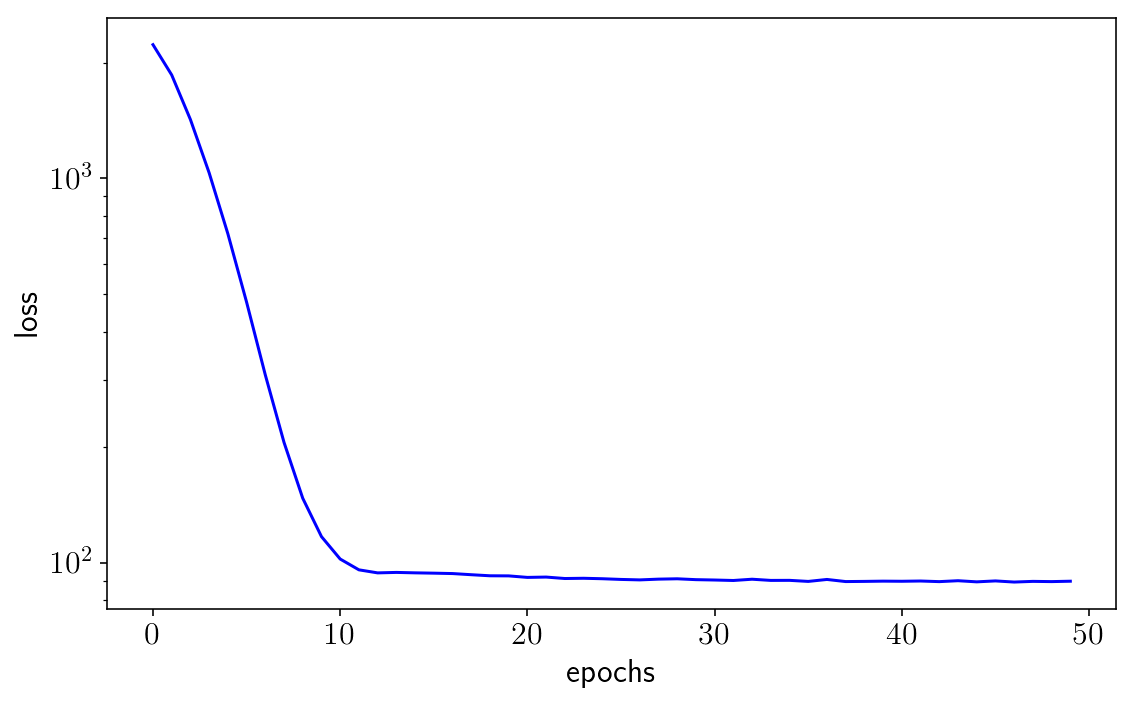

Current loss: 26.990052


In [22]:
net = nn.Sequential()
net.add(nn.Linear(n_features, 1))

criterion = nn.MSECriterion()

# Iptimizer params
optimizer_config = {'learning_rate' : 0.01, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 50
batch_size = 128

loss_history = train(net, X, y, X, y, batch_size, n_epoch, optim.nesterov, criterion,
                     optimizer_config, optimizer_state, weight_decay=True)

In [25]:
lr = LinearRegression()
lr.fit(X, y)

W_true = lr.coef_.reshape(1, n_features)

W_near = W_true + 1 * np.random.randn(*W_true.shape)

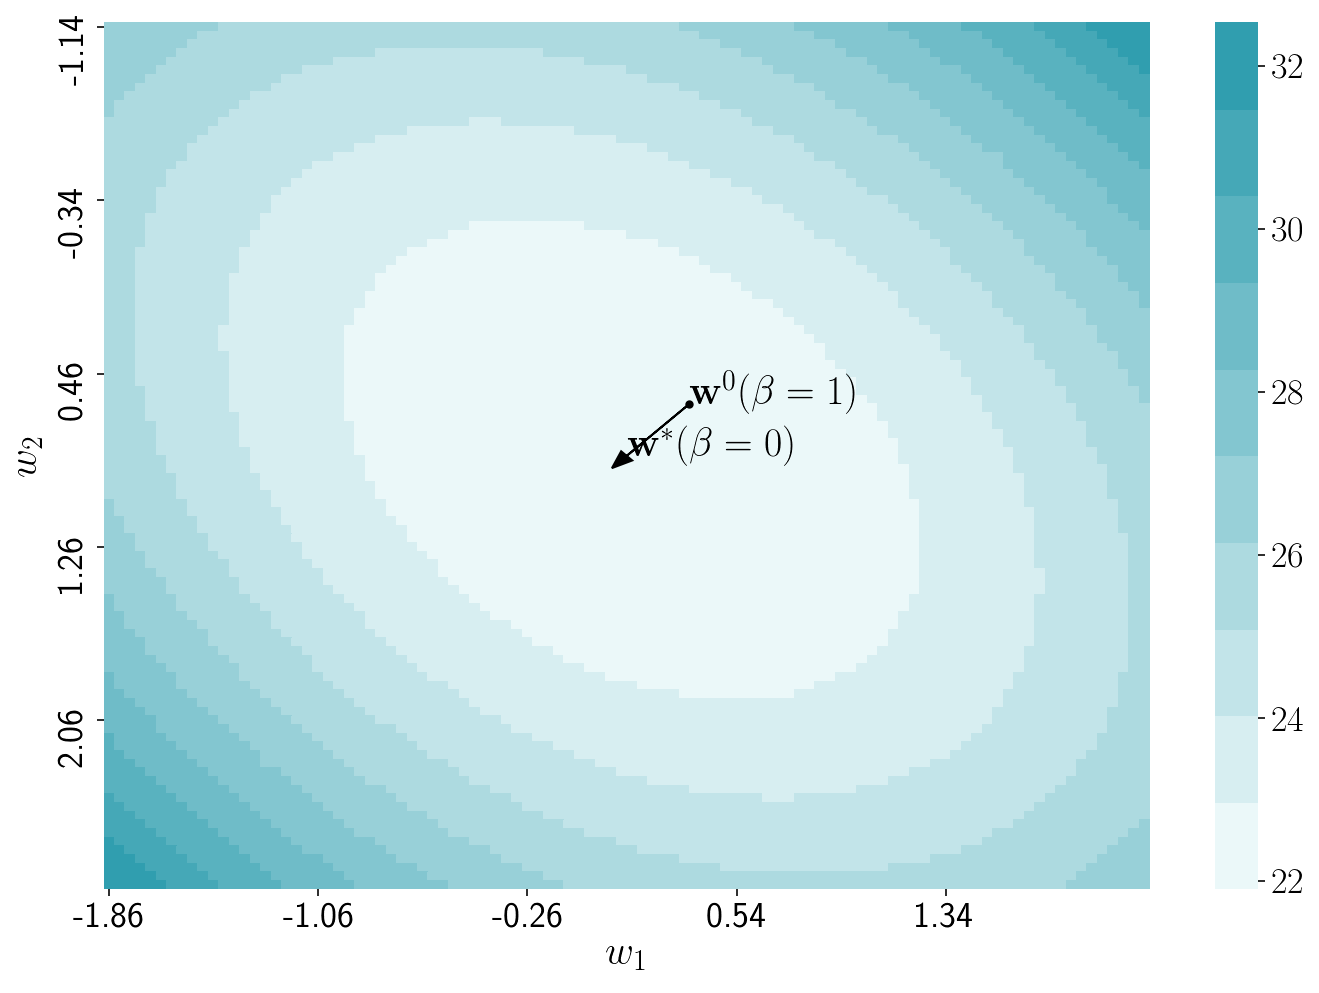

In [26]:
dw1, dw2 = 2., 2.
i1, i2 = 11, 2
k_grid = 100

i1_x, i1_y = i1 // W_true.shape[1], i1 %  W_true.shape[1]
i2_x, i2_y = i2 // W_true.shape[1], i2 %  W_true.shape[1]
Z_grid = np.zeros((k_grid, k_grid))
X_grid = [W_true[i1_x, i1_y] - dw1 + 2 * i * dw1 / k_grid for i in range(k_grid)]
Y_grid = [W_true[i2_x, i2_y] - dw2 + 2 * j * dw2 / k_grid for j in range(k_grid)]

for i, x_ in enumerate(X_grid):
    for j, y_ in enumerate(Y_grid):
        net.modules[0].W = W_true.copy()
        net.modules[0].W[i1_x, i1_y] = x_
        net.modules[0].W[i2_x, i2_y] = y_
        Z_grid[i, j] = mean_squared_error(y, net.forward(X))
        
Z_grid = pd.DataFrame(Z_grid, columns=[np.round(y_, 2) for y_ in Y_grid], index=[np.round(x_, 2) for x_ in X_grid])

plt.figure(figsize=(10, 7))
sns.heatmap(Z_grid, cmap=cmap, xticklabels=20, yticklabels=20)
idx_W_true = nearest_point(W_true[i1_x, i1_y], W_true[i2_x, i2_y], X_grid, Y_grid)
idx_W_near = nearest_point(W_near[i1_x, i1_y], W_near[i2_x, i2_y], X_grid, Y_grid)
#plt.scatter(*idx_W_true, c='k')
plt.scatter(*idx_W_near, c='k', s=10)
plt.arrow(*idx_W_near, *[x1 - x2 for x1, x2 in zip(idx_W_true, idx_W_near)], 
          head_width=1.5, head_length=2., fc='k', ec='k')
plt.xlabel(r'$w_1$')
plt.ylabel(r'$w_2$')
plt.text(*idx_W_near, r'$\mathbf{w}^0 (\beta=1)$', fontsize=20)
plt.text(*idx_W_true, r'$\mathbf{w}^* (\beta=0)$', fontsize=20)

plt.tight_layout()
plt.savefig('figs/linear_error.eps', format='eps')
plt.show()

In [27]:
fs = QPFS(sim='corr')

aff_coeffs = np.linspace(0, 1, 11)
Qs = []
bs = []

for aff_coeff in aff_coeffs:
    net.modules[0].W = (aff_coeff * W_near + (1 - aff_coeff) * W_true)
    f = net.forward(X).squeeze()
    J = get_Jacobian(X, y, net, 0)
    fs.get_Qb(J, y - f)
    Qs.append(fs.Q)
    bs.append(fs.b.squeeze())

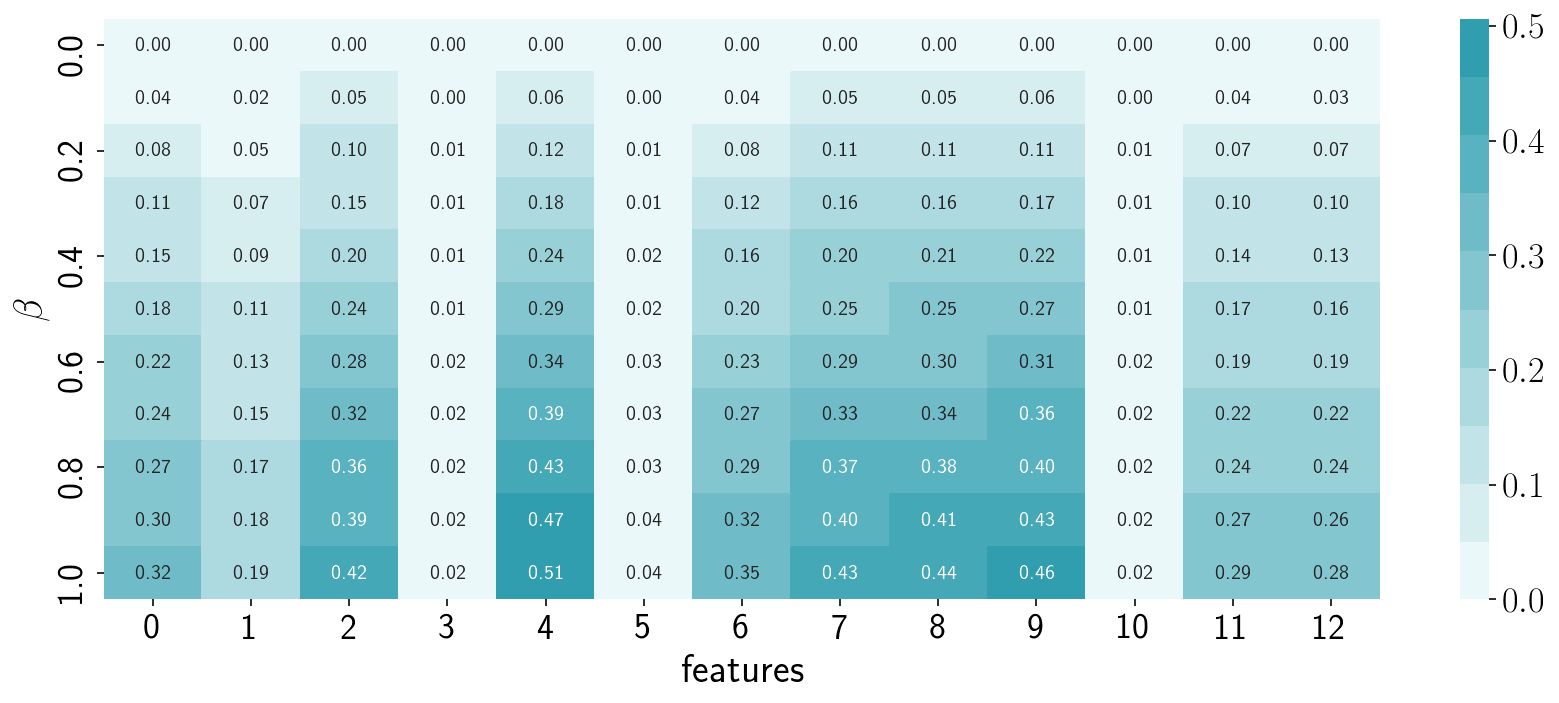

In [28]:
plt.figure(figsize=(12, 5))
bs = pd.DataFrame(np.array(bs), index=aff_coeffs)
sns.heatmap(bs, cmap=cmap, yticklabels=2, annot=True, fmt='.2f')
plt.xlabel('features')
plt.ylabel(r'$\beta$')

plt.tight_layout()
plt.savefig('figs/linear_b_wrt_beta.eps', format='eps')
plt.show()

#### 2 Линейная модель + нелинейность

$$
    f(x|w) = \sigma(Xw)
$$

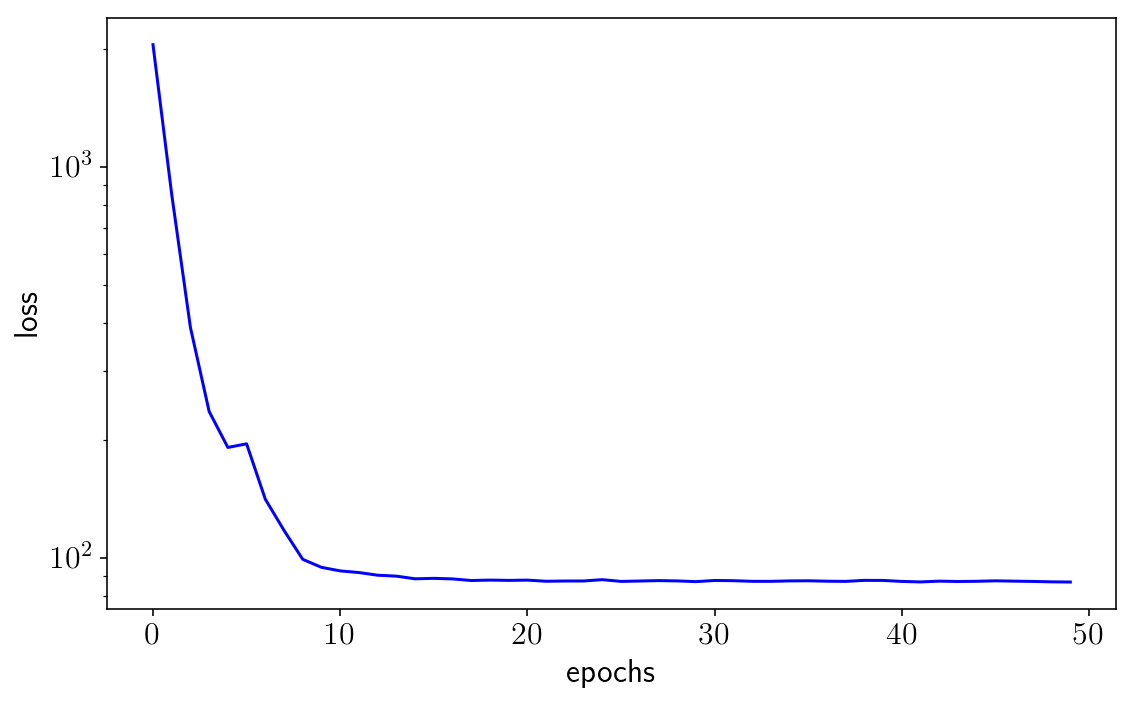

Current loss: 14.940533


In [29]:
net = nn.Sequential()
net.add(nn.Linear(n_features, 1))
net.add(nn.ELU())

criterion = nn.MSECriterion()

# Iptimizer params
optimizer_config = {'learning_rate' : 0.05, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 50
batch_size = 128

loss_history = train(net, X, y, X, y, batch_size, n_epoch, optim.nesterov, criterion,
                     optimizer_config, optimizer_state, weight_decay=True)

In [30]:
W_true = net.modules[0].W.copy()

In [31]:
W_near = W_true + 1. * np.random.randn(*W_true.shape)

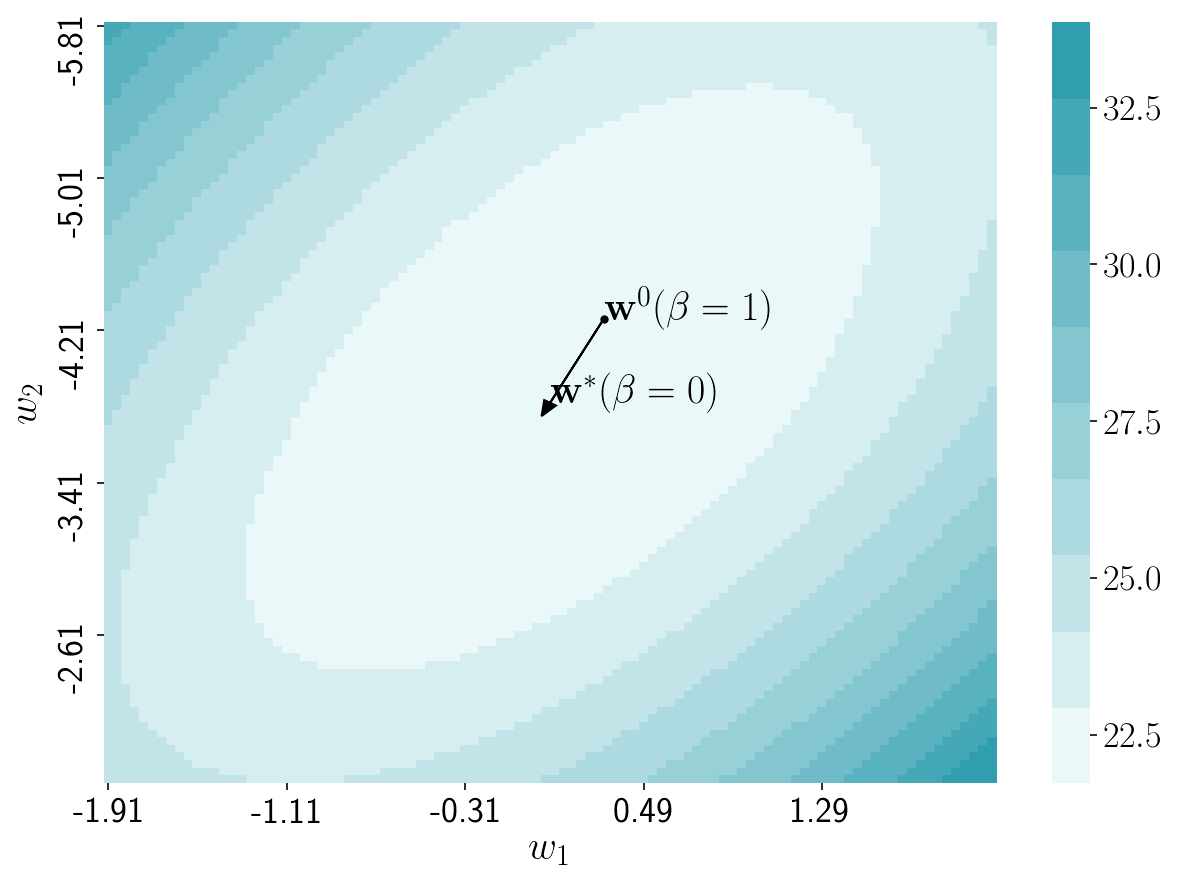

In [34]:
dw1, dw2 = 2., 2.
i1, i2 = 12, 2
k_grid = 100

i1_x, i1_y = i1 // W_true.shape[1], i1 %  W_true.shape[1]
i2_x, i2_y = i2 // W_true.shape[1], i2 %  W_true.shape[1]
Z_grid = np.zeros((k_grid, k_grid))
X_grid = [W_true[i1_x, i1_y] - dw1 + 2 * i * dw1 / k_grid for i in range(k_grid)]
Y_grid = [W_true[i2_x, i2_y] - dw2 + 2 * j * dw2 / k_grid for j in range(k_grid)]

for i, x_ in enumerate(X_grid):
    for j, y_ in enumerate(Y_grid):
        net.modules[0].W = W_true.copy()
        net.modules[0].W[i1_x, i1_y] = x_
        net.modules[0].W[i2_x, i2_y] = y_
        Z_grid[i, j] = mean_squared_error(y, net.forward(X))
        
Z_grid = pd.DataFrame(Z_grid, columns=[np.round(y_, 2) for y_ in Y_grid], index=[np.round(x_, 2) for x_ in X_grid])

plt.figure(figsize=(10, 7))
sns.heatmap(Z_grid, cmap=cmap, xticklabels=20, yticklabels=20)
idx_W_true = nearest_point(W_true[i1_x, i1_y], W_true[i2_x, i2_y], X_grid, Y_grid)
idx_W_near = nearest_point(W_near[i1_x, i1_y], W_near[i2_x, i2_y], X_grid, Y_grid)
#plt.scatter(*idx_W_true, c='k')
plt.scatter(*idx_W_near, c='k', s=10)
plt.arrow(*idx_W_near, *[x1 - x2 for x1, x2 in zip(idx_W_true, idx_W_near)], 
          head_width=1.5, head_length=2., fc='k', ec='k')
plt.xlabel(r'$w_1$')
plt.ylabel(r'$w_2$')
plt.text(*idx_W_near, r'$\mathbf{w}^0 (\beta=1)$', fontsize=20)
plt.text(*idx_W_true, r'$\mathbf{w}^* (\beta=0)$', fontsize=20)
plt.show()

In [35]:
fs = QPFS(sim='corr')

aff_coeffs = np.linspace(0, 1, 11)
Qs = []
bs = []

for aff_coeff in aff_coeffs:
    net.modules[0].W = (aff_coeff * W_near + (1 - aff_coeff) * W_true)
    f = net.forward(X).squeeze()
    J = get_Jacobian(X, y, net, 0)
    fs.get_Qb(J, y - f)
    Qs.append(fs.Q)
    bs.append(fs.b.squeeze())

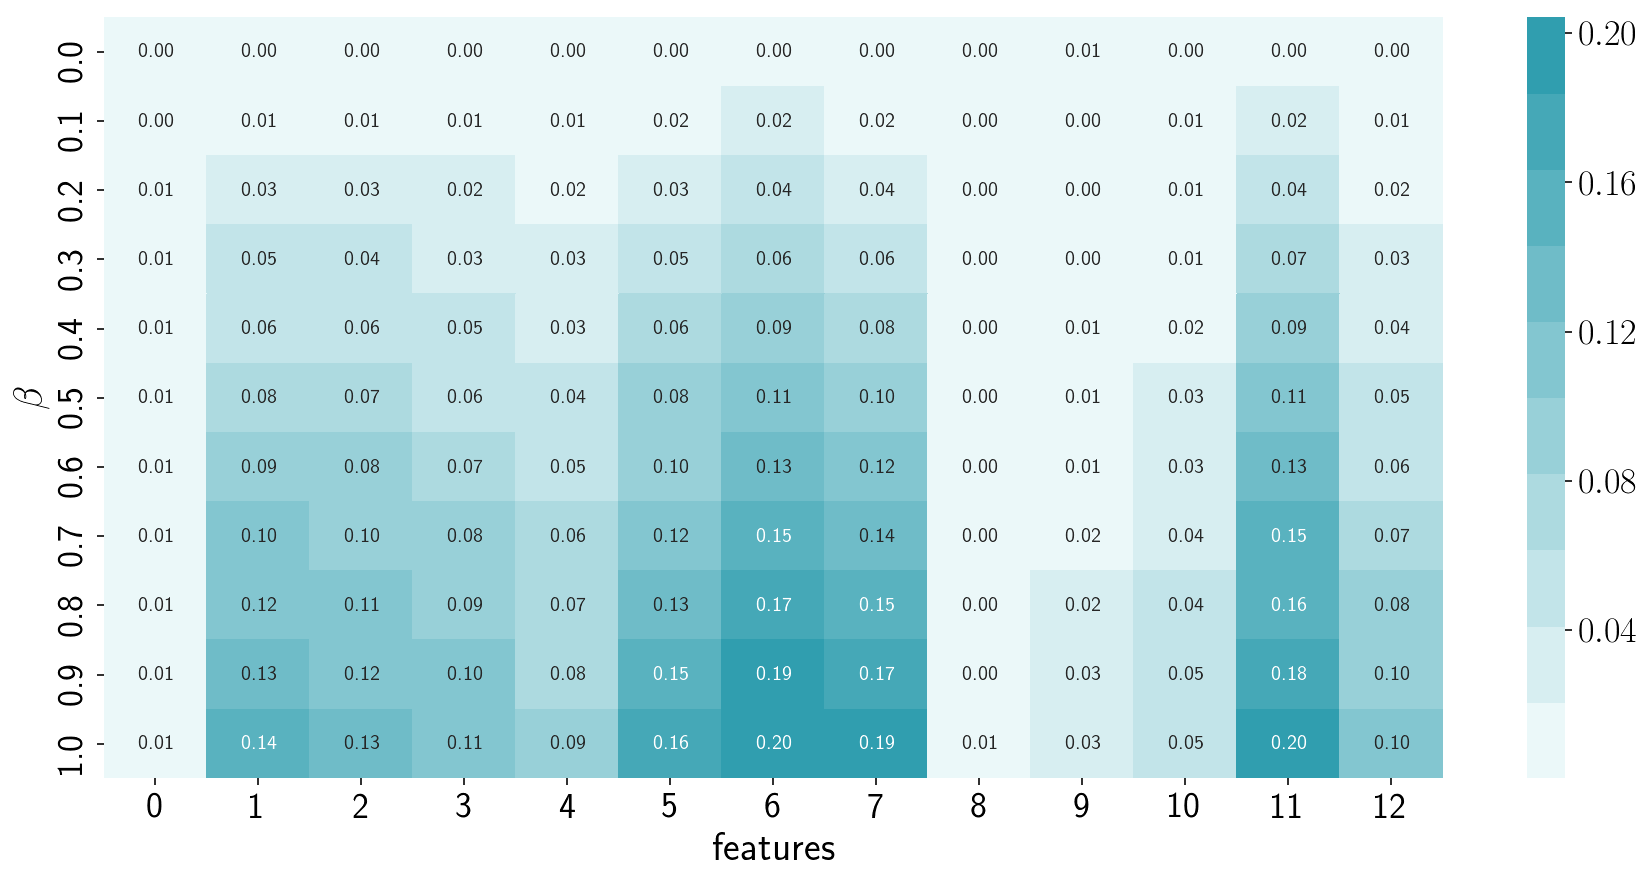

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(np.array(bs), cmap=cmap, yticklabels=aff_coeffs, annot=True, fmt='.2f')
plt.xlabel('features')
plt.ylabel(r'$\beta$')
plt.show()

#### 3 Двуслойная сеть

$$
    f(x|w) = \sigma(XW_1) W_2
$$

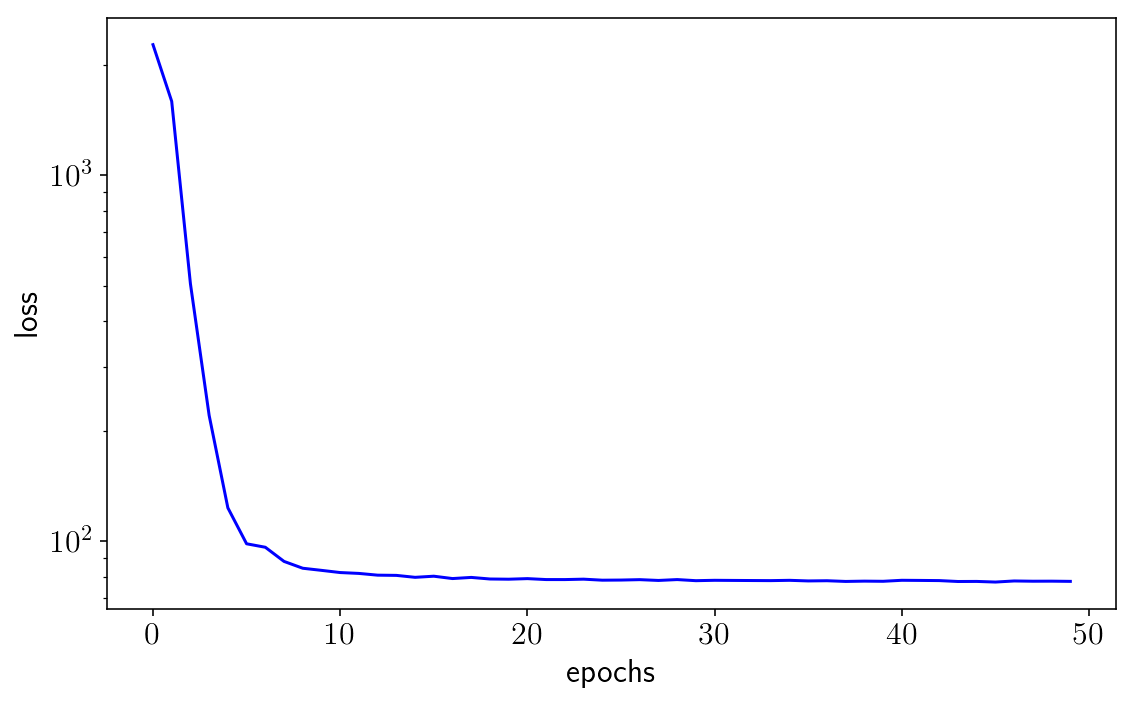

Current loss: 21.567409


In [37]:
n_hidden = 2

net = nn.Sequential()
net.add(nn.Linear(n_features, n_hidden))
net.add(nn.ELU())
net.add(nn.Linear(n_hidden, 1))

criterion = nn.MSECriterion()

# Iptimizer params
optimizer_config = {'learning_rate' : 0.01, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 50
batch_size = 128

loss_history = train(net, X, y, X, y, batch_size, n_epoch, optim.nesterov, criterion,
                     optimizer_config, optimizer_state, weight_decay=True)

In [38]:
W_true = net.modules[0].W.copy()

In [41]:
W_near = W_true + 1. * np.random.randn(*W_true.shape)

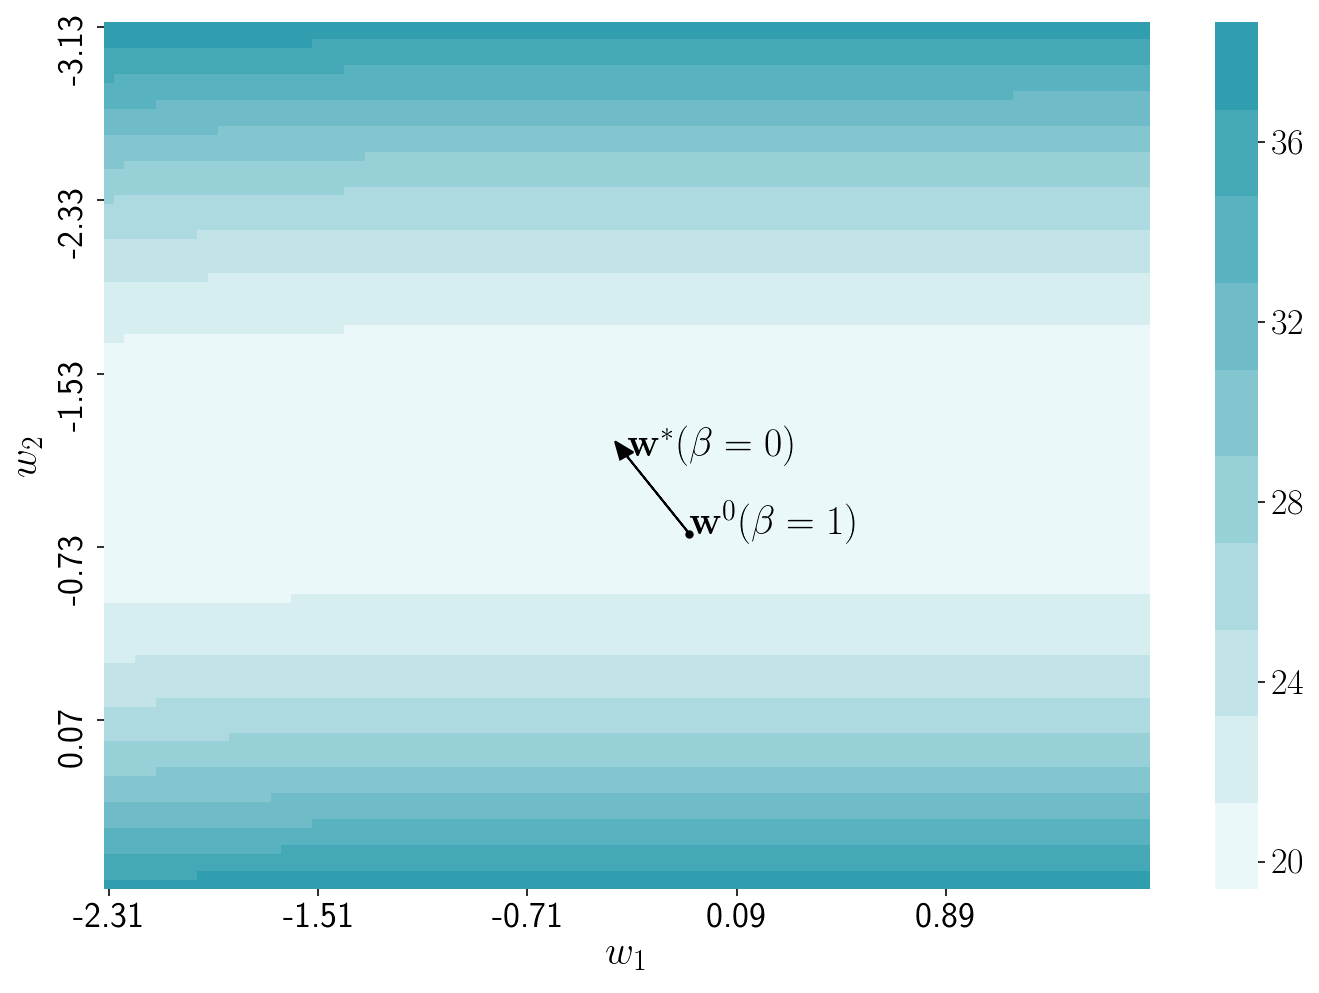

In [42]:
dw1, dw2 = 2., 2.
i1, i2 = 20, 2
k_grid = 100

i1_x, i1_y = i1 // W_true.shape[1], i1 %  W_true.shape[1]
i2_x, i2_y = i2 // W_true.shape[1], i2 %  W_true.shape[1]
Z_grid = np.zeros((k_grid, k_grid))
X_grid = [W_true[i1_x, i1_y] - dw1 + 2 * i * dw1 / k_grid for i in range(k_grid)]
Y_grid = [W_true[i2_x, i2_y] - dw2 + 2 * j * dw2 / k_grid for j in range(k_grid)]

for i, x_ in enumerate(X_grid):
    for j, y_ in enumerate(Y_grid):
        net.modules[0].W = W_true.copy()
        net.modules[0].W[i1_x, i1_y] = x_
        net.modules[0].W[i2_x, i2_y] = y_
        Z_grid[i, j] = mean_squared_error(y, net.forward(X))
        
Z_grid = pd.DataFrame(Z_grid, columns=[np.round(y_, 2) for y_ in Y_grid], index=[np.round(x_, 2) for x_ in X_grid])

plt.figure(figsize=(10, 7))
sns.heatmap(Z_grid, cmap=cmap, xticklabels=20, yticklabels=20)
idx_W_true = nearest_point(W_true[i1_x, i1_y], W_true[i2_x, i2_y], X_grid, Y_grid)
idx_W_near = nearest_point(W_near[i1_x, i1_y], W_near[i2_x, i2_y], X_grid, Y_grid)
#plt.scatter(*idx_W_true, c='k')
plt.scatter(*idx_W_near, c='k', s=10)
plt.arrow(*idx_W_near, *[x1 - x2 for x1, x2 in zip(idx_W_true, idx_W_near)], 
          head_width=1.5, head_length=2., fc='k', ec='k')
plt.xlabel(r'$w_1$')
plt.ylabel(r'$w_2$')
plt.text(*idx_W_near, r'$\mathbf{w}^0 (\beta=1)$', fontsize=20)
plt.text(*idx_W_true, r'$\mathbf{w}^* (\beta=0)$', fontsize=20)

plt.tight_layout()
plt.savefig('figs/neural_error.eps', format='eps')
plt.show()

In [43]:
fs = QPFS(sim='corr')

aff_coeffs = np.linspace(0, 1, 11)
Qs = []
bs = []

for aff_coeff in aff_coeffs:
    net.modules[0].W = (aff_coeff * W_near + (1 - aff_coeff) * W_true)
    f = net.forward(X).squeeze()
    J = get_Jacobian(X, y, net, 0)
    fs.get_Qb(J, y - f)
    Qs.append(fs.Q)
    bs.append(fs.b.squeeze())

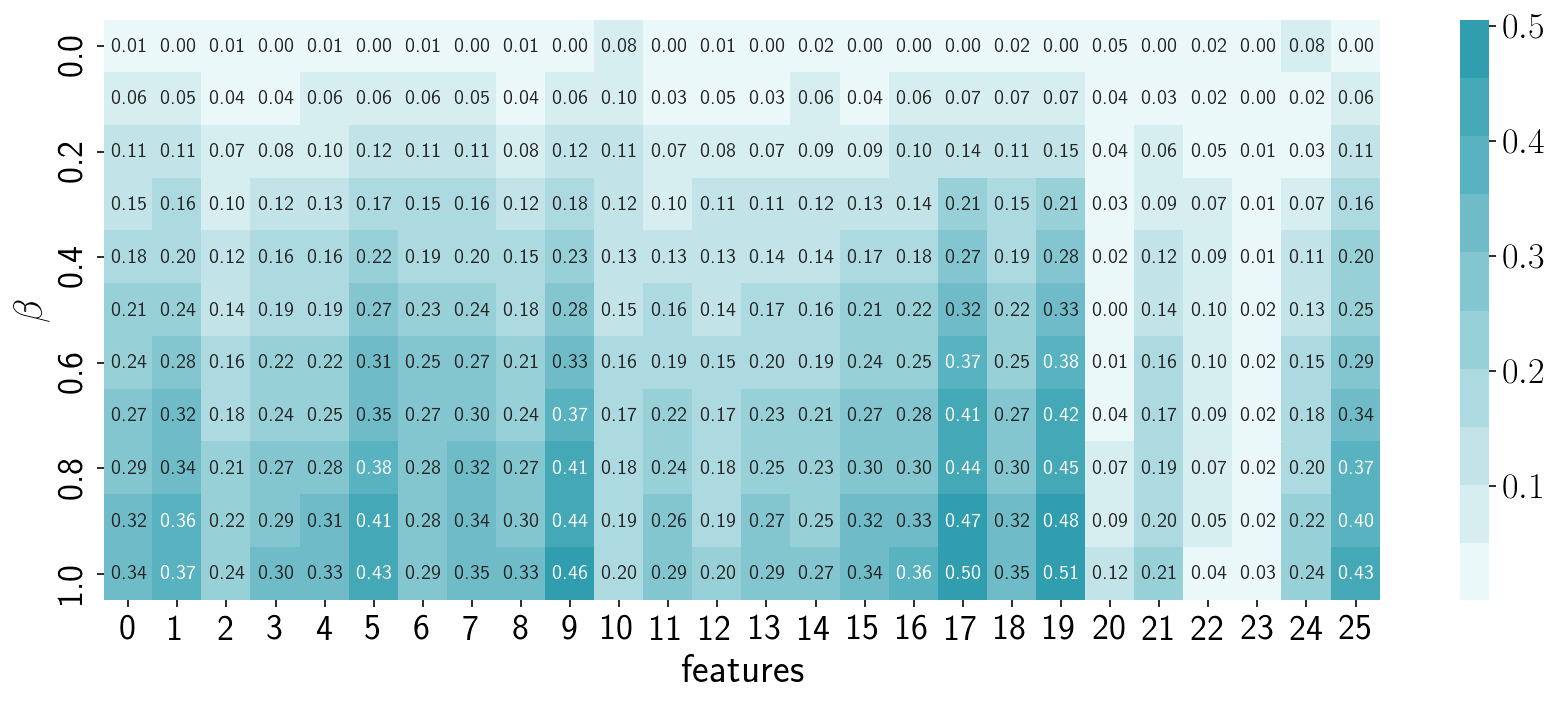

In [44]:
plt.figure(figsize=(12, 5))
bs = pd.DataFrame(np.array(bs), index=aff_coeffs)
sns.heatmap(bs, cmap=cmap, yticklabels=2, annot=True, fmt='.2f')
plt.xlabel('features')
plt.ylabel(r'$\beta$')

plt.tight_layout()
plt.savefig('figs/neural_b_wrt_beta.eps', format='eps')
plt.show()

#### Newton-Gauss

In [339]:
from sklearn.metrics import log_loss, accuracy_score

class IRLS:
    def __init__(self, add_bias=True, qpfs=False, max_iter=100, tol=1e-6, verbose=True):
        self.add_bias = add_bias
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose
        self.qpfs = QPFS(sim='corr') if qpfs else None
        self._w_history = []
        self._loss_history = []
        self._acc_history = []
    
    def fit(self, X, y):
        if self.add_bias:
            X = np.hstack([X, np.ones((X.shape[0], 1))])
        n_objects, n_features = X.shape
        self.w = np.random.randn(n_features)
        for i in range(self.max_iter):
            f = self.predict(X)
            self._w_history.append(self.w)
            self._acc_history.append(accuracy_score(y, f > 0.5))
            self._loss_history.append(log_loss(y, f))
            w_old = self.w
            if self.verbose:
                print('iter: {}, acc: {:.2f}, loss: {:.4f}'.format(i, self._acc_history[-1], self._loss_history[-1]))
            self.w = self._update_weights(X, y)
            if (np.sum((w_old - self.w) ** 2) / np.sum(self.w ** 2)) < self.tol:
                break
        self._w_history.append(self.w)
        self._acc_history.append(accuracy_score(y, f > 0.5))
        self._loss_history.append(log_loss(y, f))

    
    def _update_weights(self, X, y):
        n_features = X.shape[1]
        f = self.predict(X)
        R = np.diag(f * (1. - f))
        jac = X.T.dot(f - y)
        hes = X.T.dot(R).dot(X)
        if self.qpfs is None:
            hes = X.T.dot(R).dot(X)
            jac = X.T.dot(f - y)
            active_idxs = np.ones(n_features).astype(bool)
        else:
            F = np.sqrt(R).dot(X)
            z = (f - y) * np.sqrt(1. / (f * (1. - f)))
            self.qpfs.get_Qb(F, z)
            self.qpfs.alpha = self.qpfs.get_alpha(kind=0)
            self.qpfs.solve_problem()
            print('\t ' + ' '.join(['{:.3f}'.format(s) for s in self.qpfs.score]))
            active_idxs = self.qpfs.score > np.min([0.3, (1. / n_features)])
            F = F[:, active_idxs]
            hes = F.T.dot(F)
            jac = F.T.dot(z)
        print('\t', active_idxs)
        cond_1 = np.linalg.cond(hes)
        if cond_1 > 10:
            hes += 1. * np.eye(hes.shape[0])
        cond_2 = np.linalg.cond(hes)
        print('\t cond before: {:.3f}, cond after: {:.3f}'.format(cond_1, cond_2))
        hes_pinv = np.linalg.pinv(hes)
        w_update = np.zeros_like(self.w)
        w_update[active_idxs] = -hes_pinv.dot(jac)
        return self.w + w_update
    
    @staticmethod
    def sigmoid(x):
        s = np.zeros_like(x)
        s[x >= 0] = 1. / (1 + np.exp(-x[x >= 0]))
        s[x < 0] = np.exp(x[x < 0]) / (np.exp(x[x < 0]) + 1.)
        return s
    
    def predict(self, X):
        return self.sigmoid(X.dot(self.w))

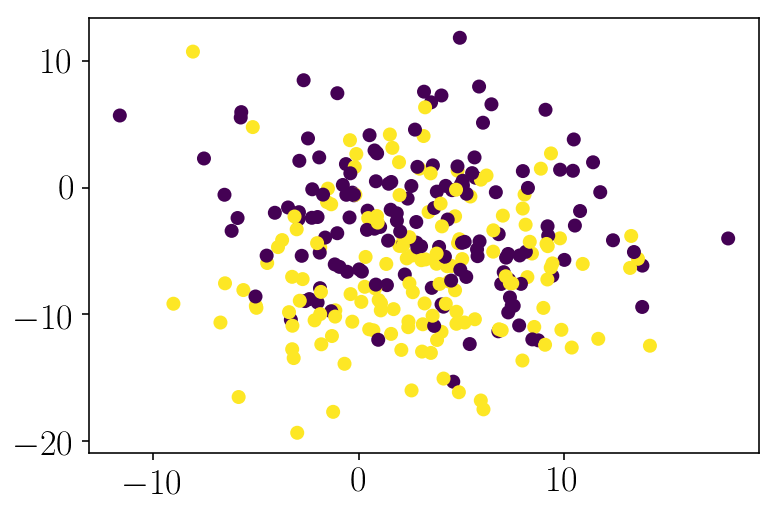

In [376]:
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression

X, y = make_blobs(n_samples=300, n_features=2, centers=2, cluster_std=5., random_state=30)
#X = (X - X.mean(0)) / X.std(axis=0)
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [377]:
lr = LogisticRegression(fit_intercept=False, C=1.)
lr.fit(X, y)
y_pred = lr.predict(X)
print(np.mean(y == y_pred))
W_true = lr.coef_.squeeze()

0.576666666667


In [378]:
irls = IRLS(add_bias=False, qpfs=True, max_iter=50)
irls.fit(X, y)

iter: 0, acc: 0.60, loss: 2.3380
	 0.419 0.581
	 [ True  True]
	 cond before: 34.411, cond after: 32.746
iter: 1, acc: 0.40, loss: 18.7740


/Users/romanisacenko/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
/Users/romanisacenko/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in multiply
/Users/romanisacenko/Desktop/QPFS/code/qpfs.py:50: RuntimeWarning: divide by zero encountered in double_scalars
  return self.Q.mean() / self.b.mean()
/Users/romanisacenko/Desktop/QPFS/code/qpfs.py:65: RuntimeWarning: invalid value encountered in multiply
  objective = cvx.Minimize(cvx.quad_form(x, self.Q) - self.alpha * self.b.T * x)


SolverError: Solver 'ECOS' failed. Try another solver.

In [380]:
irls.qpfs.alpha

inf

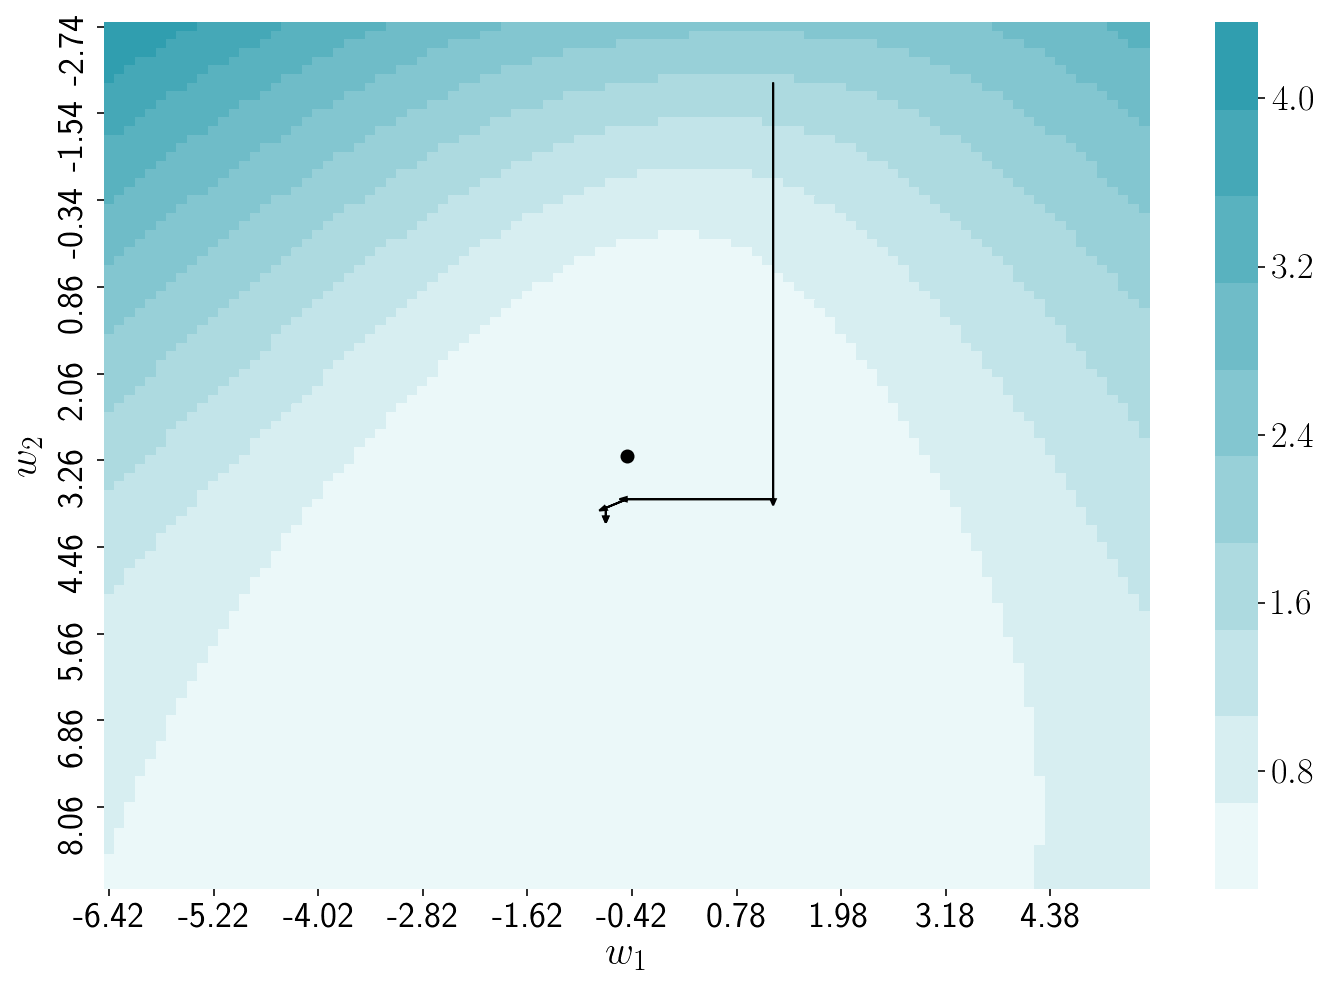

In [303]:
dw1, dw2 = 6., 6.
k_grid = 100

Z_grid = np.zeros((k_grid, k_grid))
X_grid = [W_true[0] - dw1 + 2 * i * dw1 / k_grid for i in range(k_grid)]
Y_grid = [W_true[1] - dw2 + 2 * j * dw2 / k_grid for j in range(k_grid)]

for i, x_ in enumerate(X_grid):
    for j, y_ in enumerate(Y_grid):
        W = np.array([x_, y_])
        y_pred = irls.sigmoid(X.dot(W))
        Z_grid[i, j] = log_loss(y, y_pred)
        
Z_grid = pd.DataFrame(Z_grid, columns=[np.round(y_, 2) for y_ in Y_grid], index=[np.round(x_, 2) for x_ in X_grid])

plt.figure(figsize=(10, 7))
sns.heatmap(Z_grid, cmap=cmap, xticklabels=10, yticklabels=10)
idx_W_true = nearest_point(W_true[0], W_true[1], X_grid, Y_grid)
plt.scatter(*idx_W_true, c='k')
idx_W_prev = nearest_point(irls._w_history[0][0], irls._w_history[0][1], X_grid, Y_grid)
for i in range(len(irls._w_history) - 1):
    idx_W_next = nearest_point(irls._w_history[i + 1][0], irls._w_history[i + 1][1], X_grid, Y_grid)
    plt.arrow(*idx_W_prev, *[x1 - x2 for x1, x2 in zip(idx_W_next, idx_W_prev)], 
          head_width=.5, head_length=.7, fc='k', ec='k')
    idx_W_prev = idx_W_next
plt.xlabel(r'$w_1$')
plt.ylabel(r'$w_2$')
#plt.text(*idx_W_near, r'$\mathbf{w}^0 (\beta=1)$', fontsize=20)
#plt.text(*idx_W_true, r'$\mathbf{w}^* (\beta=0)$', fontsize=20)

plt.tight_layout()
#plt.savefig('figs/neural_error.eps', format='eps')
plt.show()

In [302]:
irls._w_history

array([-1.89737698,  1.28054076])

In [240]:
X, y = load_breast_cancer(return_X_y=True)
X = (X - X.mean(axis=0)) / X.std(axis=0)

n_samples, n_features = X.shape

In [99]:
irls = IRLS(add_bias=False, qpfs=True, max_iter=10)
irls.fit(X, y)

0.000 0.076
[False False False False False False False False False  True False  True
 False False  True False False False  True False False False False False
 False False False False False  True]
cond before: 16.527, cond after: 16.484
iter: 0, acc: 0.78, loss: 0.6488
0.000 0.100
[False  True False False False False False False False  True False  True
 False False False False False False False False False False False False
 False False False False False  True]
cond before: 17.747, cond after: 17.704
iter: 1, acc: 0.86, loss: 0.3818
0.000 0.095
[False False False False False False False False False False  True False
 False False False False False False False False False  True False False
 False False False False  True  True]
cond before: 4.766, cond after: 4.763
iter: 2, acc: 0.89, loss: 0.2555
0.000 0.109
[False  True False False False False False False False False False False
 False False False False False False False False False  True False False
 False False False False False False]